In [1]:
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
import os
from os import path
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

cwd = os.getcwd()
cwd

import joblib

## Load all pyhton variables used in to create the model
## Run MLP model in other file...

In [2]:
# import geologic unit data
target_file = 'data/final_dataset/geo_meta.csv'
geo_meta = pd.read_csv(target_file, header = 0) 

#create dictionary for geologic units (coded by number)
geo_dict = geo_meta.groupby('Value')['GLG'].apply(list).to_dict()
geo_dict[1] # check
# import model data
# x_data
target_file = 'data/final_dataset/x_dat.csv'
x_dat = pd.read_csv(target_file, header = 0) 
x_dat.head()

# y data
target_file = 'data/final_dataset/y_dat.csv'
y_dat = pd.read_csv(target_file, header = 0) 
y_dat.head()
# merge to a single dataset for prep, manipulate xy varinbales in parallel
# check how many na values in each column.
data = x_dat
data['exhumation'] = y_dat['exhumation']

print(np.shape(data)) # check shape
data.isna().sum() # check variables with many missing values, remove from model?
# choose varibales for model, 
# sort and plot variables to check general relationships
var_check = (data-data.mean())/data.std()
length = len(var_check['exhumation'])
var_check = var_check.sort_values(['exhumation']).reset_index(drop=True) # sort by exhumation

# drop variables, poor correlation or lots of missing data (leave XY)
data = data.drop(labels = ['den_10Be', 'elev_10Be','slope_10Be'], axis=1)

# extract lat,long 
lon = data['X']
lat = data['Y']
data = data.dropna().reset_index(drop=True) #drop any row with an nan.
lon_modeled = data['X']
lat_modeled = data['Y']

data = data.drop(labels = ['X','Y'], axis=1)
data = data.dropna().reset_index(drop=True)

# extract geo values for re-atributation, once re-sorted by exumaiton
geo_array = np.array(data['geo'])
#geo_array = [geo_dict[i] for i in geo_array]

print(np.shape(data))
data.head()

# load x_new
target_file = 'data/final_dataset/x_new_andes1.csv'
x_new = pd.read_csv(target_file, header = 0) 
print(np.shape(x_new))
print(x_new.isna().sum())
x_new.head()

# prep x_new 
# drop na values and extract coordinets
x_new = x_new.dropna().reset_index(drop=True) #drop any row with an nan.

# extract lat,long then drop 
lon_new = x_new['X']
lat_new = x_new['Y']
x_new = x_new.drop(labels = ['X','Y'], axis=1)

np.shape(x_new)

# extract and normalize exhumation data seperetly
exhumation = np.array(data['exhumation'])
exhumation = exhumation.reshape(-1, 1)
exhumation_norm = exhumation
#scaler = StandardScaler()
#exhumation_norm = scaler.fit_transform(exhumation)
#exhumation_norm = np.array(exhumation_norm)
data = data.drop(labels = 'exhumation', axis = 1)
np.shape(data)

# append all x data for normilization
data_all = x_new.append(data, ignore_index = True, sort = None)

# check dataset shapes
data_len = np.shape(data)[0]
print(data_len) # known data length
x_new_len = np.shape(x_new)[0]
print(x_new_len) # new data length

print(data_len + x_new_len) # expected combined length
print(np.shape(data_all)) # actual combined length


scaler_x = StandardScaler()
data_all_norm = scaler_x.fit_transform(data_all)

# slice out known data for model training, and x data for predicting
data_norm = data_all_norm[x_new_len:]
data_norm_store = data_norm
data_norm = pd.DataFrame(data_norm, columns = ['precip','QSS_den','QSS_tyr','geo'])
data_norm.insert(4, 'exhumation', exhumation_norm, True)
print(np.shape(data_norm))

data_norm = data_norm.sort_values(['exhumation']).reset_index(drop=True)

x_new_norm = data_all_norm[:x_new_len]
print(np.shape(x_new_norm))
data_norm.head()

# organize data for MLP nueral network model
xy = data_norm
xy = xy.sample(frac=1).reset_index(drop=True)
xy = xy.sample(frac=1).reset_index(drop=True) # shuffle again

x = xy.drop(labels = 'exhumation', axis=1)
y = xy['exhumation']

# SEQUENTIAL SELECTION OF TRAIN/TEST & STANDARDIZED

fracTrain = 0.8 #fraction of data to use for training
ntrain = int(len(y)*fracTrain)

x_train = x[:ntrain] #train on n observations
y_train = y[:ntrain]

x_test = x[ntrain:] #test on remaining observations
y_test = y[ntrain:]

print(np.shape(x_train))
print(np.shape(x_test))

(92586, 10)
(5374, 5)
(107711, 6)
X              0
Y              0
precip      1248
QSS_den    58982
QSS_tyr    58982
geo           75
dtype: int64
5374
48376
53750
(53750, 4)
(5374, 5)
(48376, 4)
(4299, 4)
(1075, 4)


## Load in Model Results & Input Data ##

In [3]:
# read in modeled data with predictor variables (from saved model)
target_file = 'data/final_dataset/y_pred_andes_nonorm.csv'
y_pred_andes = pd.read_csv(target_file, header = 0)
y_pred_andes

,X,Y,exhumation,precip,QSS_den,QSS_tyr,geo
0,-73.269226,-49.971826,0.181616,411.897613,22.465099,73344.0,34.0
1,-73.219226,-49.971826,0.182992,397.215179,22.465099,73344.0,34.0
2,-73.169226,-49.971826,0.261852,504.246460,22.465099,73344.0,4.0
3,-73.119226,-49.971826,0.265138,450.249481,22.465099,73344.0,4.0
4,-73.269226,-49.921826,0.181901,463.785828,22.465099,73344.0,34.0
...,...,...,...,...,...,...,...
48371,-66.469226,10.378174,0.194288,1381.984741,7.084390,72654.0,11.0
48372,-66.419226,10.378174,0.182186,1588.460327,7.262930,98505.0,11.0
48373,-66.369226,10.378174,0.181691,1614.172485,7.262930,98505.0,11.0
48374,-66.319226,10.378174,0.205909,1574.192993,7.262930,98505.0,14.0


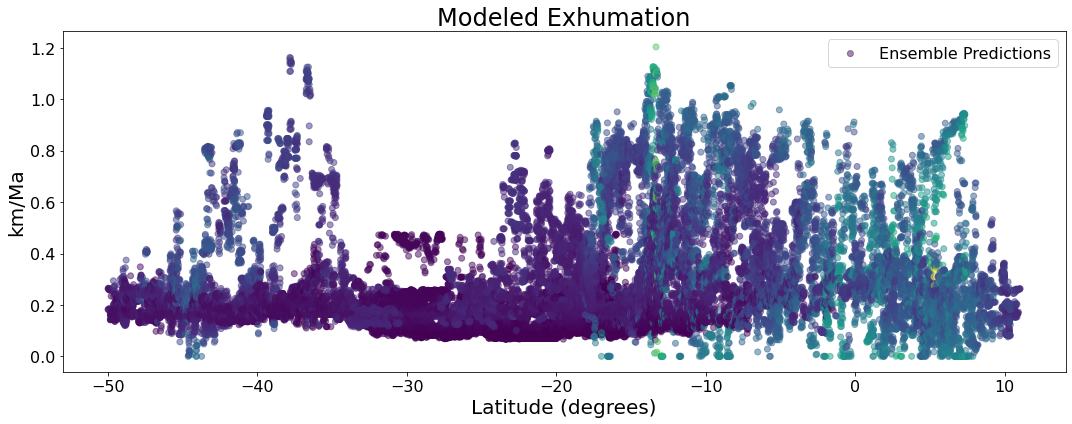

In [4]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data

saveIt = 0

plt.figure(figsize = (15,6))
plt.scatter(y_pred_andes['Y'], y_pred_andes['exhumation'],label='Ensemble Predictions', c =  y_pred_andes['precip'], cmap = 'viridis', alpha = 0.5)

plt.xlabel('Latitude (degrees)', fontsize = 20)
plt.ylabel('km/Ma', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Modeled Exhumation', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('model_predictions.png')

plt.show()

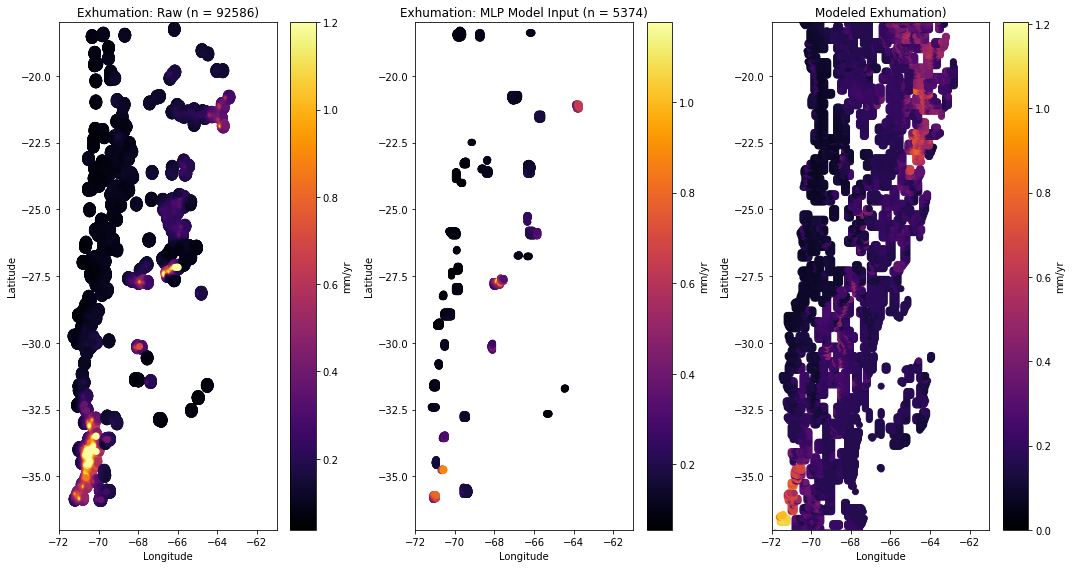

In [5]:
# plot predictions spatially
n_raw = np.shape(x_dat)[0]
n_input = np.shape(data)[0]
n_model = np.shape(x_new)[0]


plt.figure(figsize = (15,8))

plt.subplot(131)
plt.scatter(x_dat['X'],x_dat['Y'], c = x_dat['exhumation'], cmap = 'inferno', vmax = 1.2)
plt.colorbar(label = 'mm/yr')
#plt.scatter(lon_modeled,lat_modeled, c = exhumation, cmap = 'hot')
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Exhumation: Raw (n = {})'.format(n_raw))

plt.subplot(132)
plt.scatter(lon_modeled,lat_modeled, c = exhumation, cmap = 'inferno')
plt.colorbar(label = 'mm/yr')
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Exhumation: MLP Model Input (n = {})'.format(n_input))


plt.subplot(133)
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'], cmap = 'inferno')
#plt.scatter(x_dat['X'],x_dat['Y'], c = 'red', vmax = 2)
plt.colorbar(label = 'mm/yr')
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Modeled Exhumation)')

plt.tight_layout()


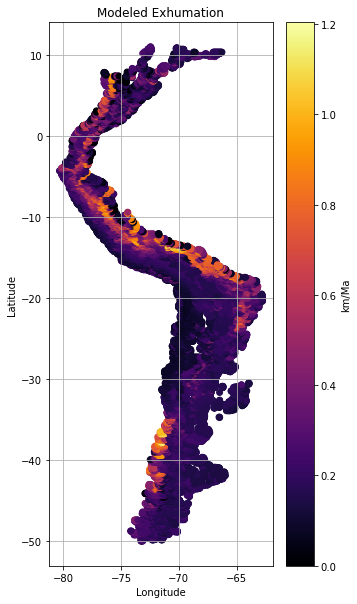

In [6]:
plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'], cmap = 'inferno')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Modeled Exhumation')
plt.colorbar(label = 'km/Ma')


In [56]:
# by 1 degree lat
# lon width wont work sice the trange bends

lat_start = np.arange(10, -49, -1).tolist()
lat_end = np.arange(9, -50, -1).tolist()

lon_width = []
avg_ex = []
avg_precip = []
avg_den = []
avg_tyr = []

for i, j in zip(lat_start, lat_end):
    arr_min = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].min()
    arr_max = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].max()
    width = arr_max - arr_min
    
    ex_mean = y_pred_andes['exhumation'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    precip_mean = y_pred_andes['precip'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    den_mean = y_pred_andes['QSS_den'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    tyr_mean = y_pred_andes['QSS_tyr'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    
    lon_width.append(width)
    avg_ex.append(ex_mean)
    avg_precip.append(precip_mean)
    avg_den.append(den_mean)
    avg_tyr.append(tyr_mean)

lon_width_km = np.array(lon_width)*113.3
den_km_ma = np.array(avg_den) * 0.000001 # to km/ ka
den_km_ma = den_km_ma * 1000 # to km/Ma

ex_over_den = np.array(avg_ex)/np.array(den_km_ma) # av_den
ex_min_den = np.array(avg_ex) - np.array(den_km_ma)

width = pd.DataFrame({'width':lon_width,
                      'width_km': lon_width_km, #convert from degrees to km
                         'avg_ex':avg_ex,
                        'avg_precip': avg_precip,
                        'avg_den': avg_den,
                      'avg_tyr': avg_tyr,
                      'ex_over_den':ex_over_den,
                     'ex_min_den': ex_min_den})
#width = width.sort_values(by=['avg_ex']).reset_index(drop = True)

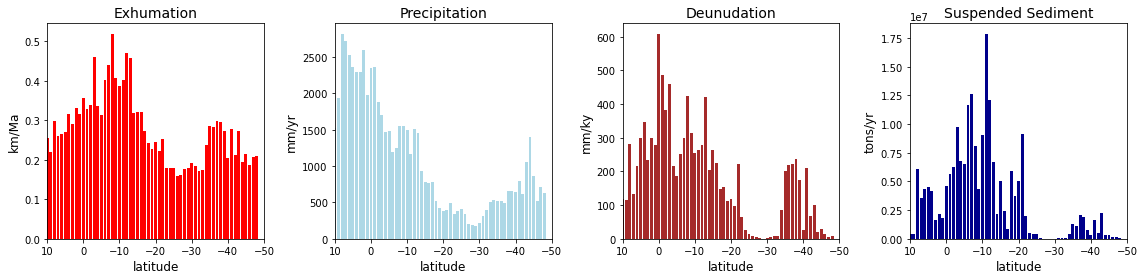

In [11]:
#width = width.sort_values(by=['width']).reset_index(drop = True)
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.bar(lat_start,width['avg_ex'], color = 'red')
plt.ylabel('km/Ma', size = 12)
plt.title('Exhumation', size = 14)
plt.xlabel('latitude', size = 12)
plt.xlim(10, -50)


plt.subplot(142)
plt.bar(lat_start,width['avg_precip'], color = 'lightblue')
plt.ylabel('mm/yr', size = 12)
plt.title('Precipitation', size = 14)
plt.xlabel('latitude', size = 12)
plt.xlim(10, -50)

plt.subplot(143)
plt.bar(lat_start,width['avg_den'], color = 'brown')
plt.ylabel('mm/ky', size = 12)
plt.title('Deunudation', size = 14)
plt.xlabel('latitude', size = 12)
plt.xlim(10, -50)

plt.subplot(144)
plt.bar(lat_start,width['avg_tyr'], color = 'darkblue')
plt.ylabel('tons/yr', size = 12)
plt.title('Suspended Sediment', size = 14)
plt.xlabel('latitude', size = 12)
plt.xlim(10, -50)

plt.tight_layout()

NameError: name 'line_list' is not defined

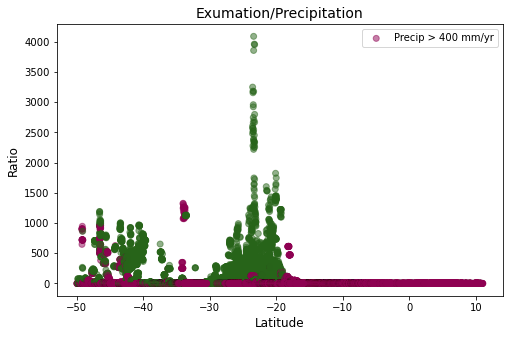

In [9]:
# explore relative relations
test =  y_pred_andes['exhumation']/y_pred_andes['QSS_den']

plt.figure(figsize = (8,5))
plt.scatter(lat_new, test, c = y_pred_andes['precip']<400, cmap = 'PiYG', alpha = 0.5, label = 'Precip > 400 mm/yr')
plt.xlabel('Latitude', size = 12)
plt.ylabel('Ratio', size = 12)
plt.title('Exumation/Precipitation', size = 14)
plt.legend()

for i in line_list:
    plt.axvline(x=i, color='r', linestyle='-')
plt.xlim()

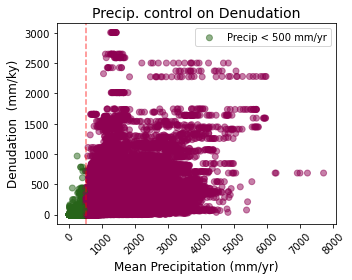

In [52]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data


plt.figure(figsize = (5,4))
plt.scatter(y_pred_andes['precip'], y_pred_andes['QSS_den'], alpha = 0.5, c = y_pred_andes['precip']<500, cmap = 'PiYG', label = 'Precip < 500 mm/yr')

plt.xlabel('Mean Precipitation (mm/yr)', fontsize = 12)
plt.ylabel('Denudation  (mm/ky)', fontsize = 12)
plt.title('Precip. control on Denudation', size = 14)
plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)
plt.axvline(x=500, color='r', linestyle='--', alpha = 0.5)
#plt.title('', fontsize = 24)
#plt.legend(fontsize = 16, loc = 'best')
#plt.xlim(0,6000)
#plt.ylim(0,2000)
plt.legend()
plt.tight_layout()


plt.show()

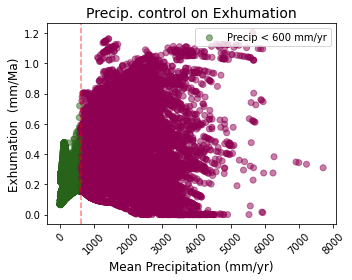

In [53]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data


plt.figure(figsize = (5,4))
plt.scatter(y_pred_andes['precip'], y_pred_andes['exhumation'], alpha = 0.5, c = y_pred_andes['precip']<600,cmap = 'PiYG', label = 'Precip < 600 mm/yr')

plt.xlabel('Mean Precipitation (mm/yr)', fontsize = 12)
plt.ylabel('Exhumation  (mm/Ma)', fontsize = 12)
plt.title('Precip. control on Exhumation', size = 14)
plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)
plt.axvline(x=600, color='r', linestyle='--', alpha = 0.5)
#plt.title('', fontsize = 24)
#plt.legend(fontsize = 16, loc = 'best')
#plt.xlim(0,6000)
#plt.ylim(0,2000)
plt.legend()
plt.tight_layout()


plt.show()

linear: y=[5.58]x+[[-0.53]]
Power funtion: y = [265.07]x^[[-0.53]]


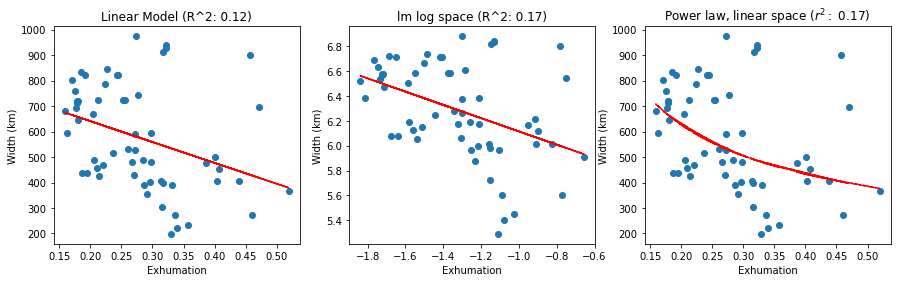

In [14]:
# Fit Power law or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width = width.sort_values(by=['avg_ex']).reset_index(drop = True)

X_start = np.array(width_copy['avg_ex']).reshape(-1,1)
X = X_start
Y_start = np.array(np.array(width_copy['width_km']).reshape(-1,1))
Y = Y_start

#X = np.array(width_copy['ex_over_den']).reshape(-1,1)
#Y = np.array(np.array(width_copy['width_km']).reshape(-1,1))

# run linear regression
model_lm = LinearRegression().fit(X,Y)
Y_pred_lm = model_lm.predict(X)
r2_lm = model_lm.score(X,Y)

# take natural log
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = (np.exp(X))

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Exhumation')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Exhumation')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))

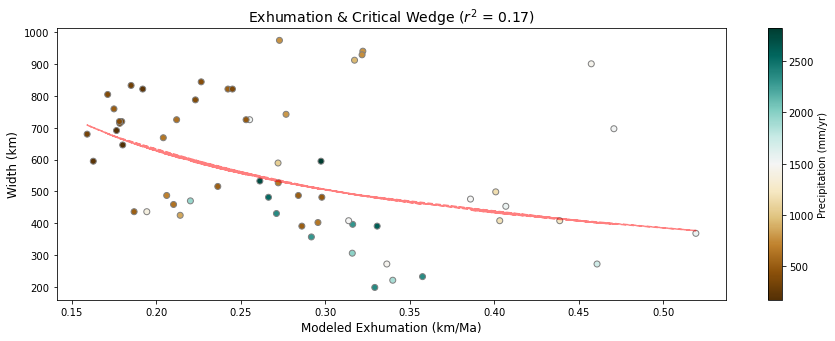

In [15]:
precip_plot = np.array(np.array(width_copy['avg_precip']).reshape(-1,1))

# plot regresson nice
plt.figure(figsize = (15,5))
plt.scatter(X_start, Y_start, c = precip_plot, cmap = 'BrBG', edgecolors='gray')
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--', alpha = 0.5)
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Modeled Exhumation (km/Ma)', size = 12)
plt.title('Exhumation & Critical Wedge ($r^2$ = {})'.format(r2), size = 14)
plt.colorbar(label = 'Precipitation (mm/yr)')

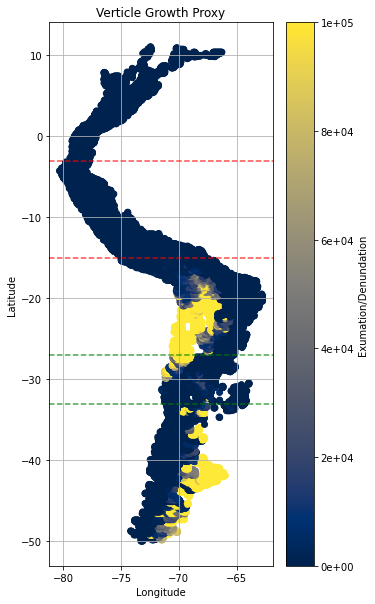

In [17]:
# exumation over denundation
den_km_ma_all = np.array(y_pred_andes['QSS_den']) * 0.000001 # to km/ ka
den_km_ma_all = den_km_ma_all * 1000 # to km/Ma

plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'] / den_km_ma_all, cmap = 'cividis', vmax = 1e5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Verticle Growth Proxy')
plt.colorbar(label = 'Exumation/Denundation', format='%.0e')

FS1 = [-3,-15] # flat-slab zone 1 (Espurt et al., 2008)
FS2 = [-27,-33] # flat-slab zone 2 (Espurt et al., 2008)

for i in FS1:
    plt.axhline(y=i, color='red', linestyle='--', alpha = 0.7)

for i in FS2:
    plt.axhline(y=i, color='green', linestyle='--', alpha = 0.7)


linear: y=[6.18]x+[[0.1]]
Power funtion: y = [482.99]x^[[0.1]]


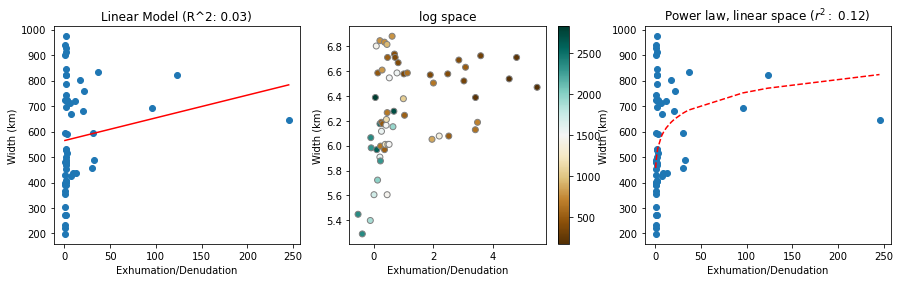

In [69]:
# Fit Power law or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width_copy = width.sort_values(by=['ex_over_den']).reset_index(drop = True)

X_start = np.array(width_copy['ex_over_den']).reshape(-1,1)
X = X_start
Y_start = np.array(np.array(width_copy['width_km']).reshape(-1,1))
Y = Y_start

#X = np.array(width_copy['ex_over_den']).reshape(-1,1)
#Y = np.array(np.array(width_copy['width_km']).reshape(-1,1))

# run linear regression
model_lm = LinearRegression().fit(X,Y)
Y_pred_lm = model_lm.predict(X)
r2_lm = model_lm.score(X,Y)

# take natural log
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = (np.exp(X))

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y, c = width_copy['avg_precip'], cmap = 'BrBG', edgecolors='gray')
plt.colorbar()
#plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('log space')# (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))

Text(0.5, 1.0, 'log space')

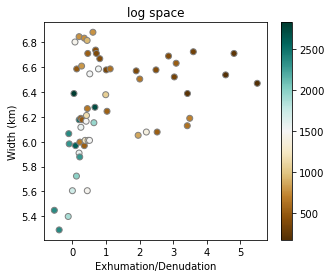

In [71]:
plt.figure(figsize = (5,4))
plt.scatter(X, Y, c = width_copy['avg_precip'], cmap = 'BrBG', edgecolors='gray')
plt.colorbar()
#plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('log space')# (R^2: {})'.format(r2))

linear: y=[5.96]x+[[0.87]]
Power funtion: y = [387.61]x^[[0.87]]


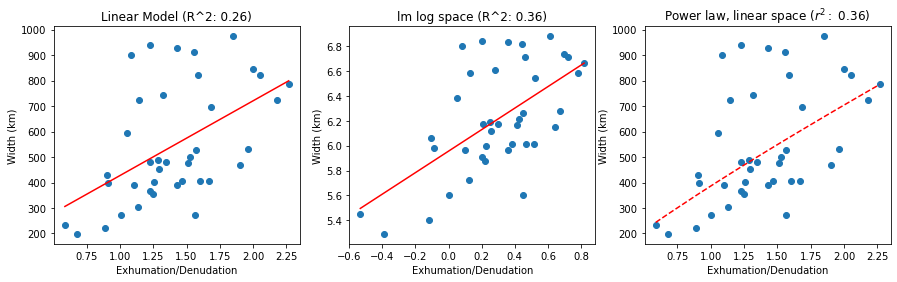

In [61]:
# LOOKS LIKE A POWER LAW THAT TAPERS OFF, CHECK EARLY DATA ONLY
# Fit Power law or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width_copy = width.sort_values(by=['ex_over_den']).reset_index(drop = True)
X_start = np.array(width_copy['ex_over_den'][width_copy['ex_over_den'] <2.5]).reshape(-1,1)
X = X_start

Y_start = np.array(np.array(width_copy['width_km'][width_copy['ex_over_den'] <2.5]).reshape(-1,1))
Y = Y_start

#X = np.array(width_copy['ex_over_den']).reshape(-1,1)
#Y = np.array(np.array(width_copy['width_km']).reshape(-1,1))

# run linear regression
model_lm = LinearRegression().fit(X,Y)
Y_pred_lm = model_lm.predict(X)
r2_lm = model_lm.score(X,Y)

# take natural log
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = (np.exp(X))

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))


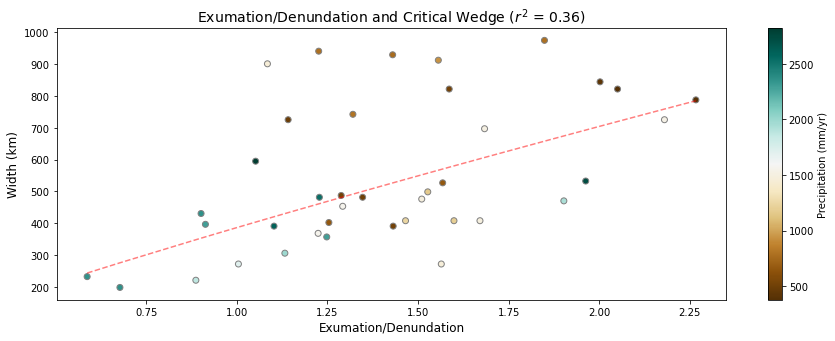

In [62]:
precip_plot = np.array(np.array(width_copy['avg_precip'][width_copy['ex_over_den'] <2.5]).reshape(-1,1))

# plot regresson nice
plt.figure(figsize = (15,5))
plt.scatter(X_start, Y_start, c = precip_plot, cmap = 'BrBG', edgecolors='gray')
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--', alpha = 0.5)
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Exumation/Denundation', size = 12)
plt.title('Exumation/Denundation and Critical Wedge ($r^2$ = {})'.format(r2), size = 14)
plt.colorbar(label = 'Precipitation (mm/yr)')

### Exumation - Denudation ?
#### all units in km/ ma

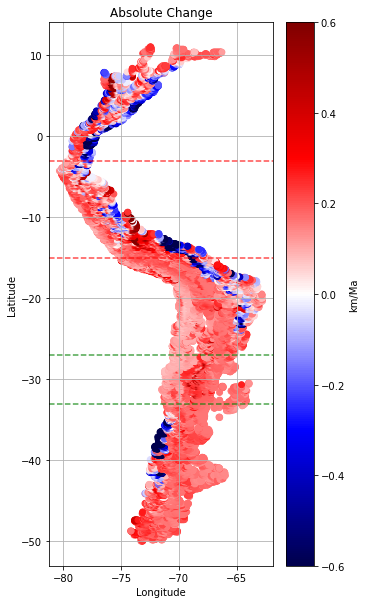

In [40]:
# exumation over denundation
den_km_ma_all = np.array(y_pred_andes['QSS_den']) * 0.000001 # to km/ ka
den_km_ma_all = den_km_ma_all * 1000 # to km/Ma

plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'] - den_km_ma_all, cmap = 'seismic', vmin = -.6, vmax = .6) # limit range so 0 is white
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Absolute Change')
plt.colorbar(label = 'km/Ma')

FS1 = [-3,-15] # flat-slab zones, norhten, central, and Andes
FS2 = [-27,-33] # flat-slab zones, norhten, central, and Andes
for i in FS1:
    plt.axhline(y=i, color='red', linestyle='--', alpha = 0.7)
for i in FS2:
    plt.axhline(y=i, color='green', linestyle='--', alpha = 0.7)

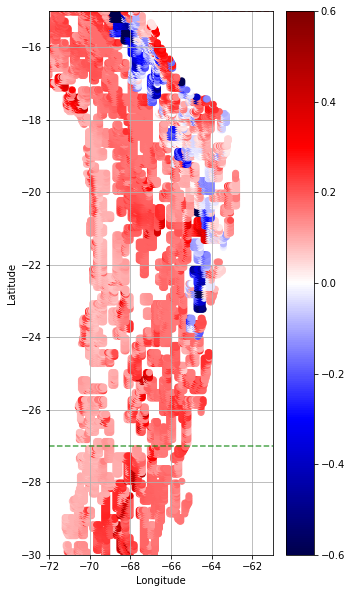

In [64]:
# exumation over denundation
den_km_ma_all = np.array(y_pred_andes['QSS_den']) * 0.000001 # to km/ ka
den_km_ma_all = den_km_ma_all * 1000 # to km/Ma

plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'] - den_km_ma_all, cmap = 'seismic', vmin = -.6, vmax = 0.6) # limit range so 0 is white
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.xlim(-72,-61)
plt.ylim(-30,-15)
plt.colorbar()

FS1 = [-3,-15] # flat-slab zones, norhten, central, and Andes
FS2 = [-27,-33] # flat-slab zones, norhten, central, and Andes
for i in FS1:
    plt.axhline(y=i, color='red', linestyle='--', alpha = 0.7)
for i in FS2:
    plt.axhline(y=i, color='green', linestyle='--', alpha = 0.7)

linear: y=[5.34]x+[[3.16]]
Power funtion: y = [208.51]x^[[3.16]]


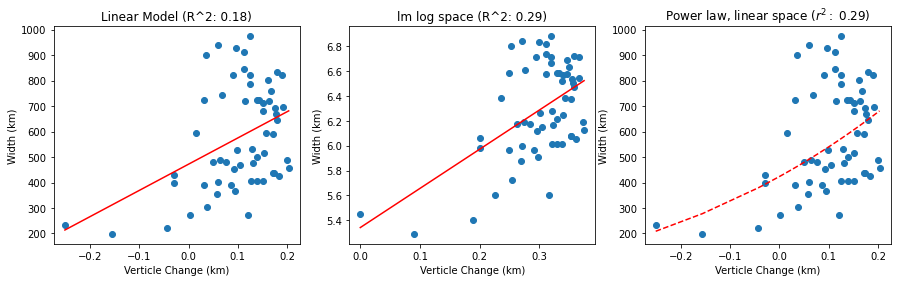

In [28]:
# Fit Power law function or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width_copy = width.sort_values(by=['ex_min_den']).reset_index(drop = True)

X_start = np.array(width_copy['ex_min_den']).reshape(-1,1)
X = X_start

Y_start = np.array(np.array(width_copy['width_km']).reshape(-1,1))
Y = Y_start


# run linear regression
model_lm = LinearRegression().fit(X_start,Y_start)
Y_pred_lm = model_lm.predict(X_start)
r2_lm = model_lm.score(X_start,Y_start)

# take natural log
X = (X - X.min()) + 1
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = ((np.exp(X)) -1)  + X_start.min()

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))


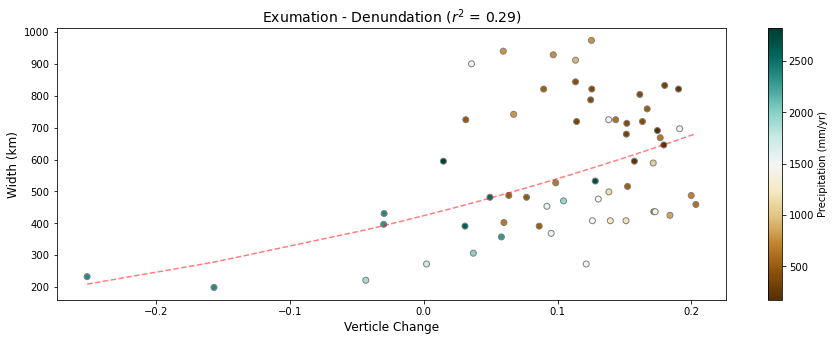

In [29]:
precip_plot = np.array(np.array(width_copy['avg_precip']).reshape(-1,1))

# plot regresson nice
plt.figure(figsize = (15,5))
plt.scatter(X_start, Y_start, c = precip_plot, cmap = 'BrBG', edgecolors='gray')
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--', alpha = 0.5)
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Verticle Change', size = 12)
plt.title('Exumation - Denundation ($r^2$ = {})'.format(r2), size = 14)
plt.colorbar(label = 'Precipitation (mm/yr)')

In [36]:
# by geogrpahic unit
# Northern Andes, Flat Slab 1, Central Andes, Flat Slab 2, SOuthern Andes
# lon width wont work sice the trange bends

lat_start = [10,-3,-15,-27,-33]
lat_end = [-3,-15,-27,-33,-50]

#lon_width = []
avg_ex = []
avg_precip = []
avg_den = []
avg_tyr = []

for i, j in zip(lat_start, lat_end):
    #arr_min = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].min()
    #arr_max = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].max()
    width = arr_max - arr_min
    
    ex_mean = y_pred_andes['exhumation'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    precip_mean = y_pred_andes['precip'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    den_mean = y_pred_andes['QSS_den'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    tyr_mean = y_pred_andes['QSS_tyr'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    
    #lon_width.append(width)
    avg_ex.append(ex_mean)
    avg_precip.append(precip_mean)
    avg_den.append(den_mean)
    avg_tyr.append(tyr_mean)

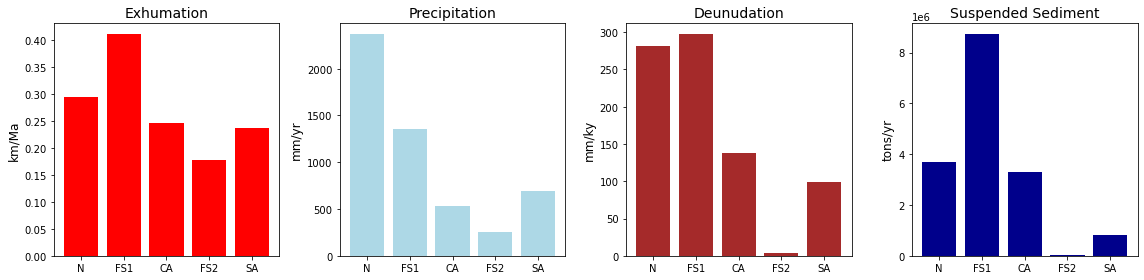

In [37]:
width = pd.DataFrame({ 'avg_ex':avg_ex,
                        'avg_precip': avg_precip,
                        'avg_den': avg_den,
                      'avg_tyr': avg_tyr,
                      'geog':['N','FS1','CA','FS2','SA']})

#width = width.sort_values(by=['width']).reset_index(drop = True)
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.bar(width['geog'],width['avg_ex'], color = 'red')
plt.ylabel('km/Ma', size = 12)
plt.title('Exhumation', size = 14)

plt.subplot(142)
plt.bar(width['geog'],width['avg_precip'], color = 'lightblue')
plt.ylabel('mm/yr', size = 12)
plt.title('Precipitation', size = 14)

plt.subplot(143)
plt.bar(width['geog'],width['avg_den'], color = 'brown')
plt.ylabel('mm/ky', size = 12)
plt.title('Deunudation', size = 14)

plt.subplot(144)
plt.bar(width['geog'],width['avg_tyr'], color = 'darkblue')
plt.ylabel('tons/yr', size = 12)
plt.title('Suspended Sediment', size = 14)

plt.tight_layout()